In [40]:
import matplotlib.pyplot as plt
import autograd.numpy as np
import autograd.scipy.stats as sps_autograd
from autograd import grad, hessian, jacobian
from statsmodels.tsa.arima_process import ArmaProcess
from scipy.optimize import minimize
from scipy.linalg import toeplitz
import pandas as pd

In [41]:
"""
Simulate ARMA(1, 1) model
"""
a = 0.5
b = 0.2
# Define AR and MA coefficients
ar = np.array([1, -a])  
ma = np.array([1, -b])        

# Create ARMA process object
arma_process = ArmaProcess(ar, ma)

# Simulate 500 samples
N = 400
y = arma_process.generate_sample(nsample=N, scale=2) # scale is the variance of the white noise

In [42]:
def initiate_KF_parameter_values(theta, sigma2):
    """
    Initialise the parameters for the Kalman Filter
    """
    # region Initial values for Kalman Filter
    a, b = theta
    k = len(theta)

    # Simple operations that autograd can handle
    F = np.array([[a, 1.0], [0.0, 0.0]])
    G = np.array([[1.0], [-b]])
    H = np.array([[1.0, 0.0]])
    Q = np.eye(k)
    dF = np.array([
        [[1, 0], [0, 0]],  # First parameter (AR coefficient)
        [[0, 0], [0, 0]]   # Second parameter (MA coefficient)
        ])
    dF.reshape(2, 2, 2)
    dG = np.array([
        [[0], [0]],  # First parameter (AR coefficient)
        [[0], [-1.0]]   # Second parameter (MA coefficient)
        ])
    dG.reshape(2, 2, 1)

    g = np.array([1.0, a - b, a * (a - b)])

    C = np.array([
        sigma2 * (1 - 2 * a * b + b**2) / (1 - a**2),
        a * (sigma2 * (1 - 2 * a * b + b**2) / (1 - a**2)) - sigma2 * b,
        a * (a * (sigma2 * (1 - 2 * a * b + b**2) / (1 - a**2)) - sigma2 * b)
    ])

    V = np.array([
        [C[0], -b * g[0]],
        [-b * g[0], b**2 * sigma2]
    ])

    dV = np.array([
        [[(2 * sigma2 * (a-b) * (1 - a*b)) / (1 - a**2)**2, 0],
        [0, 0]],
        [[2 * sigma2 * (b-a) / (1 - a**2), -1],
        [-1, 2 * b * sigma2]]
    ])

    # Initialize the x and dx
    x = np.zeros((k, 1))
    dx = np.zeros((2, 2, 1))

    return F, G, H, dF, dG, V, dV, x, dx, k

In [43]:
def analytical_grad_hess(theta, init_sigma2):
    a, b = theta
    k = 2
    sigma2 = init_sigma2  # CHANGE PARAMETER HERE

    # Simple operations that autograd can handle
    F = np.array([[a, 1.0], [0.0, 0.0]])
    G = np.array([[1.0], [-b]])
    H = np.array([[1.0, 0.0]])
    Q = np.eye(k)
    dF = np.array([
        [[1, 0], [0, 0]],  # First parameter (AR coefficient)
        [[0, 0], [0, 0]]   # Second parameter (MA coefficient)
        ])
    dF.reshape(2, 2, 2)
    dG = np.array([
        [[0], [0]],  # First parameter (AR coefficient)
        [[0], [-1.0]]   # Second parameter (MA coefficient)
        ])
    dG.reshape(2, 2, 1)

    g = np.array([1.0, a - b, a * (a - b)])

    C = np.array([
        sigma2 * (1 - 2 * a * b + b**2) / (1 - a**2),
        a * (sigma2 * (1 - 2 * a * b + b**2) / (1 - a**2)) - sigma2 * b,
        a * (a * (sigma2 * (1 - 2 * a * b + b**2) / (1 - a**2)) - sigma2 * b)
    ])

    V = np.array([
        [C[0], -b * g[0]],
        [-b * g[0], b**2 * sigma2]
    ])

    dV = np.array([
        [[(2 * sigma2 * (a-b) * (1 - a*b)) / (1 - a**2)**2, 0],
        [0, 0]],
        [[2 * sigma2 * (b-a) / (1 - a**2), -1],
        [-1, 2 * b * sigma2]]
    ])

    # Initialize the x and dx
    x = np.zeros((k, 1))
    dx = np.zeros((2, 2, 1))

    # Dictionary to store the values
    dict = {
        'analytical_grad_at_i': [],
        'log_likelihood_at_i': [],
    }

    # Initialize the values
    sigma2_hat_sum = 0.0
    dsigma2_hat_sum = np.array([[0.0], [0.0]]).reshape(2, 1, 1)
    log_r_sum = 0.0


    # Run the Kalman filter for gradient
    for t in range(N):
        # Set the current sample size
        n = t + 1
        

        # 1. Predict
        # Predict one-step-ahead state predictive density of x_{t}
        x_predict = F @ x
        V_predict = F @ V @ F.T + G @ G.T

        # Compute forecast error and one-step-ahead predictive variance
        e_t = y[t] - (H @ x_predict)[0, 0]
        r_t = (H @ V_predict @ H.T)[0, 0]

        GdGT = np.array([G @ dG.T[0][i].reshape(1,2) for i in range(2)])

        # Kalman filter for gradient
        dx_predict = F @ dx + dF @ x
        dV_predict = F @ dV @ F.T + dF @ V @ F.T + F @ V @ dF.T + dG @ G.T + GdGT
        # dV_predict = F @ dV @ F.T + dF @ V @ F.T + F @ V @ dF.T + dG @ G.T + G @ Q @ dG.T


        # Calculate de_t and dr_t as tensor(2,1,1)
        de_t = -H @ dx_predict
        dr_t = H @ dV_predict @ H.T

        # Update sigma2 hat and gradient of sigma2 hat
        sigma2_hat_sum += e_t**2 / r_t
        sigma2_hat = sigma2_hat_sum / n
        dsigma2_hat_sum += (2 * e_t * de_t) /r_t - (e_t**2 * dr_t) / (r_t**2)
        dsigma2_hat = dsigma2_hat_sum / n

        # Update the r
        log_r_sum += np.log(r_t)

        # 2. Update
        # Kalman gain
        K = V_predict @ H.T / r_t

        # Update current state and covariance
        x = x_predict + K * e_t
        V = (np.eye(k) - K @ H) @ V_predict

        dK = (dV_predict @ H.T / r_t) - (V_predict @ H.T / r_t**2) @ dr_t
        dx = dx_predict + K @ de_t + dK * e_t
        dV = dV_predict - dK @ H @ V_predict - K @ H @ dV_predict
        
        # Compute sigma2_hat and gradient of the log-likelihood
        log_likelihood_at_i = -0.5 * (np.log(2 * np.pi) 
                                + np.log(sigma2_hat) 
                                + np.log(r_t) + e_t**2 / (r_t * sigma2_hat))  
        
        """
        analytical_grad = - (e_t * de_t) / (sigma2_hat * r_t) \
                                + (e_t**2 * dr_t) / (2 * sigma2_hat * r_t**2) \
                                - dr_t / (2 * r_t)
        """
        
        analytical_grad_at_i = - 0.5 * (dsigma2_hat / sigma2_hat 
                                    + dr_t / r_t 
                                    + (2 * e_t * sigma2_hat * r_t * de_t - e_t**2 * r_t * dsigma2_hat - e_t**2 * sigma2_hat * dr_t) / (sigma2_hat**2 * r_t**2)
                                    )
        

        dict['analytical_grad_at_i'].append(analytical_grad_at_i.flatten())
        dict['log_likelihood_at_i'].append(log_likelihood_at_i)

    log_likelihood = -0.5 * (N * np.log(2 * np.pi) 
                            + N * np.log(sigma2_hat) 
                            # + np.sum(np.log(r)) + N)
                            + log_r_sum + N)

    # Return the dictionary
    return dict, sigma2_hat, log_likelihood



In [44]:
"""

# Initialize the parameters
theta = np.array([-0.2, 0.1])
init_sigma2 = 0.5

# Dataframe to store the results
df = pd.DataFrame(columns=['t', 'analytical_hess', 'auto_hess', 'equal'])

for t in range(N):
    # Analytical gradient
    obj_func_gradient = lambda param: analytical_grad_hess(param, init_sigma2)[0]['analytical_grad_at_i'][t]
    jacobian_obj_func_gradient = jacobian(obj_func_gradient)
    auto_jacobian_val = jacobian_obj_func_gradient(theta)

    # Auto Hessian
    obj_func_likelihood = lambda param: analytical_grad_hess(param, init_sigma2)[0]['log_likelihood_at_i'][t]
    hess_obj_func_likelihood = hessian(obj_func_likelihood)
    auto_hess_val = hess_obj_func_likelihood(theta)

    # Store the results
    df.loc[t, 't'] = t
    df.loc[t, 'analytical_hess'] = auto_jacobian_val
    df.loc[t, 'auto_hess'] = auto_hess_val
    df.loc[t, 'equal'] = np.allclose(auto_jacobian_val, auto_hess_val)

# Check the results
print(sum(df['equal']) == N)
df.tail()

"""

"\n\n# Initialize the parameters\ntheta = np.array([-0.2, 0.1])\ninit_sigma2 = 0.5\n\n# Dataframe to store the results\ndf = pd.DataFrame(columns=['t', 'analytical_hess', 'auto_hess', 'equal'])\n\nfor t in range(N):\n    # Analytical gradient\n    obj_func_gradient = lambda param: analytical_grad_hess(param, init_sigma2)[0]['analytical_grad_at_i'][t]\n    jacobian_obj_func_gradient = jacobian(obj_func_gradient)\n    auto_jacobian_val = jacobian_obj_func_gradient(theta)\n\n    # Auto Hessian\n    obj_func_likelihood = lambda param: analytical_grad_hess(param, init_sigma2)[0]['log_likelihood_at_i'][t]\n    hess_obj_func_likelihood = hessian(obj_func_likelihood)\n    auto_hess_val = hess_obj_func_likelihood(theta)\n\n    # Store the results\n    df.loc[t, 't'] = t\n    df.loc[t, 'analytical_hess'] = auto_jacobian_val\n    df.loc[t, 'auto_hess'] = auto_hess_val\n    df.loc[t, 'equal'] = np.allclose(auto_jacobian_val, auto_hess_val)\n\n# Check the results\nprint(sum(df['equal']) == N)\ndf.t

# Test Hessian function 1

In [45]:
# OPTIMIZED HESSIAN COMPUTATION - FINITE DIFFERENCES
print("Using finite differences for Hessian computation (faster than jacobian)...")

def compute_hessian_fast(thetaStar, init_sigma2):
    """Fast Hessian computation using finite differences"""
    N = len(y)
    p = len(thetaStar)
    eps = 1e-5
    
    Hess_all = np.zeros((N, p, p))
    
    # Get base gradients
    grad_result = analytical_grad_hess(thetaStar, init_sigma2)
    grad_base = np.stack(grad_result[0]['analytical_grad_at_i'], axis=0)  # (N, p)
    
    for i in range(p):
        theta_plus = thetaStar.copy()
        theta_plus[i] += eps
        
        grad_plus_result = analytical_grad_hess(theta_plus, init_sigma2)
        grad_plus = np.stack(grad_plus_result[0]['analytical_grad_at_i'], axis=0)
        
        # Finite difference approximation
        Hess_all[:, i, :] = (grad_plus - grad_base) / eps
        print(f"Processed parameter {i+1}/{p}")
    
    return Hess_all

Using finite differences for Hessian computation (faster than jacobian)...


# Test Hessian function 2

In [46]:
"""
import jax.numpy as jnp
import jax
from jax import jit, vmap, grad, hessian
import numpy as np
"""

'\nimport jax.numpy as jnp\nimport jax\nfrom jax import jit, vmap, grad, hessian\nimport numpy as np\n'

In [47]:
"""
# JAX version - nhanh hơn 10-50x
def analytical_grad_hess_jax(theta, init_sigma2, y):
    """"""JAX version of analytical_grad_hess - much faster""""""
    N = len(y)
    
    # JAX-compatible Kalman filter implementation
    def kf_step(carry, t):
        x, V, dx, dV, sigma2_hat_sum, dsigma2_hat_sum = carry
        
        # Predict
        x_predict = F @ x
        V_predict = F @ V @ F.T + G @ G.T
        
        # Forecast error
        e_t = y[t] - (H @ x_predict)[0, 0]
        r_t = (H @ V_predict @ H.T)[0, 0]
        
        # Gradient calculations
        dx_predict = F @ dx + dF @ x
        dV_predict = F @ dV @ F.T + dF @ V @ F.T + F @ V @ dF.T + dG @ G.T + GdGT
        
        de_t = -H @ dx_predict
        dr_t = H @ dV_predict @ H.T
        
        # Update
        sigma2_hat_sum += e_t**2 / r_t
        sigma2_hat = sigma2_hat_sum / (t + 1)
        dsigma2_hat_sum += (2 * e_t * de_t) / r_t - (e_t**2 * dr_t) / (r_t**2)
        dsigma2_hat = dsigma2_hat_sum / (t + 1)
        
        # Kalman gain
        K = V_predict @ H.T / r_t
        x = x_predict + K * e_t
        V = (jnp.eye(k) - K @ H) @ V_predict
        
        dK = (dV_predict @ H.T / r_t) - (V_predict @ H.T / r_t**2) @ dr_t
        dx = dx_predict + K @ de_t + dK * e_t
        dV = dV_predict - dK @ H @ V_predict - K @ H @ dV_predict
        
        # Log-likelihood and gradient
        log_likelihood_at_i = -0.5 * (jnp.log(2 * jnp.pi) + jnp.log(sigma2_hat) + 
                                     jnp.log(r_t) + e_t**2 / (r_t * sigma2_hat))
        
        analytical_grad_at_i = -0.5 * (dsigma2_hat / sigma2_hat + dr_t / r_t + 
                                      (2 * e_t * sigma2_hat * r_t * de_t - 
                                       e_t**2 * r_t * dsigma2_hat - 
                                       e_t**2 * sigma2_hat * dr_t) / (sigma2_hat**2 * r_t**2))
        
        return (x, V, dx, dV, sigma2_hat_sum, dsigma2_hat_sum), (log_likelihood_at_i, analytical_grad_at_i.flatten())
    
    # Initialize
    F, G, H, dF, dG, V, dV, x, dx, k = initiate_KF_parameter_values(theta, init_sigma2)
    GdGT = jnp.array([G @ dG.T[0][i].reshape(1,2) for i in range(2)])
    
    # Run scan
    carry_init = (x, V, dx, dV, 0.0, jnp.zeros((2, 1, 1)))
    _, (log_likelihoods, gradients) = jax.lax.scan(kf_step, carry_init, jnp.arange(N))
    
    return {'log_likelihood_at_i': log_likelihoods, 'analytical_grad_at_i': gradients}

# JIT compile for speed
analytical_grad_hess_jax = jit(analytical_grad_hess_jax)

# Vectorized Hessian calculation
def compute_hessian_fast(thetaStar, init_sigma2, y):
    """"""Fast Hessian calculation using JAX""""""
    N = len(y)
    
    def grad_per_obs(theta):
        return analytical_grad_hess_jax(theta, init_sigma2, y)['analytical_grad_at_i']
    
    # Vectorized gradient function
    grads_all = vmap(grad_per_obs, in_axes=0)  
    
    # Compute Hessian for all observations at once
    Hess_all = jax.jacfwd(grads_all)(thetaStar)
    
    return Hess_all
"""

"\n# JAX version - nhanh hơn 10-50x\ndef analytical_grad_hess_jax(theta, init_sigma2, y):\n    JAX version of analytical_grad_hess - much faster\n    N = len(y)\n    \n    # JAX-compatible Kalman filter implementation\n    def kf_step(carry, t):\n        x, V, dx, dV, sigma2_hat_sum, dsigma2_hat_sum = carry\n        \n        # Predict\n        x_predict = F @ x\n        V_predict = F @ V @ F.T + G @ G.T\n        \n        # Forecast error\n        e_t = y[t] - (H @ x_predict)[0, 0]\n        r_t = (H @ V_predict @ H.T)[0, 0]\n        \n        # Gradient calculations\n        dx_predict = F @ dx + dF @ x\n        dV_predict = F @ dV @ F.T + dF @ V @ F.T + F @ V @ dF.T + dG @ G.T + GdGT\n        \n        de_t = -H @ dx_predict\n        dr_t = H @ dV_predict @ H.T\n        \n        # Update\n        sigma2_hat_sum += e_t**2 / r_t\n        sigma2_hat = sigma2_hat_sum / (t + 1)\n        dsigma2_hat_sum += (2 * e_t * de_t) / r_t - (e_t**2 * dr_t) / (r_t**2)\n        dsigma2_hat = dsigma2_

# Test 3

In [48]:
"""
# OPTIMIZED HESSIAN COMPUTATION - IMPROVED FINITE DIFFERENCES
print("Using improved finite differences for Hessian computation...")

def compute_hessian_fast(thetaStar, init_sigma2, method='central', eps=1e-6):
    Improved Hessian computation using finite differences
    
    Parameters:
    - method: 'forward', 'central', or 'adaptive'
    - eps: step size (will be optimized for adaptive method)
    
    N = len(y)
    p = len(thetaStar)
    
    Hess_all = np.zeros((N, p, p))
    
    # Get base gradients
    grad_result = analytical_grad_hess(thetaStar, init_sigma2)
    grad_base = np.stack(grad_result[0]['analytical_grad_at_i'], axis=0)  # (N, p)
    
    if method == 'forward':
        # Forward difference (original method)
        for i in range(p):
            theta_plus = thetaStar.copy()
            theta_plus[i] += eps
            
            grad_plus_result = analytical_grad_hess(theta_plus, init_sigma2)
            grad_plus = np.stack(grad_plus_result[0]['analytical_grad_at_i'], axis=0)
            
            Hess_all[:, i, :] = (grad_plus - grad_base) / eps
            print(f"Processed parameter {i+1}/{p} (forward difference)")
    
    elif method == 'central':
        # Central difference (more accurate)
        for i in range(p):
            theta_plus = thetaStar.copy()
            theta_minus = thetaStar.copy()
            theta_plus[i] += eps
            theta_minus[i] -= eps
            
            grad_plus_result = analytical_grad_hess(theta_plus, init_sigma2)
            grad_minus_result = analytical_grad_hess(theta_minus, init_sigma2)
            grad_plus = np.stack(grad_plus_result[0]['analytical_grad_at_i'], axis=0)
            grad_minus = np.stack(grad_minus_result[0]['analytical_grad_at_i'], axis=0)
            
            Hess_all[:, i, :] = (grad_plus - grad_minus) / (2 * eps)
            print(f"Processed parameter {i+1}/{p} (central difference)")
    
    elif method == 'adaptive':
        # Adaptive step size for better accuracy
        for i in range(p):
            # Try different step sizes and choose the most stable one
            eps_candidates = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
            best_eps = eps_candidates[0]
            min_condition_number = float('inf')
            
            for test_eps in eps_candidates:
                theta_plus = thetaStar.copy()
                theta_minus = thetaStar.copy()
                theta_plus[i] += test_eps
                theta_minus[i] -= test_eps
                
                grad_plus_result = analytical_grad_hess(theta_plus, init_sigma2)
                grad_minus_result = analytical_grad_hess(theta_minus, init_sigma2)
                grad_plus = np.stack(grad_plus_result[0]['analytical_grad_at_i'], axis=0)
                grad_minus = np.stack(grad_minus_result[0]['analytical_grad_at_i'], axis=0)
                
                hess_approx = (grad_plus - grad_minus) / (2 * test_eps)
                
                # Check condition number for stability
                try:
                    condition_num = np.linalg.cond(hess_approx)
                    if condition_num < min_condition_number:
                        min_condition_number = condition_num
                        best_eps = test_eps
                        Hess_all[:, i, :] = hess_approx
                except:
                    continue
            
            print(f"Processed parameter {i+1}/{p} (adaptive, best eps={best_eps:.0e})")
    
    return Hess_all
    """

'\n# OPTIMIZED HESSIAN COMPUTATION - IMPROVED FINITE DIFFERENCES\nprint("Using improved finite differences for Hessian computation...")\n\ndef compute_hessian_fast(thetaStar, init_sigma2, method=\'central\', eps=1e-6):\n    Improved Hessian computation using finite differences\n    \n    Parameters:\n    - method: \'forward\', \'central\', or \'adaptive\'\n    - eps: step size (will be optimized for adaptive method)\n    \n    N = len(y)\n    p = len(thetaStar)\n    \n    Hess_all = np.zeros((N, p, p))\n    \n    # Get base gradients\n    grad_result = analytical_grad_hess(thetaStar, init_sigma2)\n    grad_base = np.stack(grad_result[0][\'analytical_grad_at_i\'], axis=0)  # (N, p)\n    \n    if method == \'forward\':\n        # Forward difference (original method)\n        for i in range(p):\n            theta_plus = thetaStar.copy()\n            theta_plus[i] += eps\n            \n            grad_plus_result = analytical_grad_hess(theta_plus, init_sigma2)\n            grad_plus = np.

In [49]:

# OPTIMIZED HESSIAN COMPUTATION - IMPROVED FINITE DIFFERENCES
print("Using improved finite differences for Hessian computation...")

def compute_hessian_fast(thetaStar, init_sigma2, eps=1e-6):
    """Improved Hessian computation using finite differences
    
    Parameters:
    - method: 'forward', 'central', or 'adaptive'
    - eps: step size (will be optimized for adaptive method)
    """
    N = len(y)
    p = len(thetaStar)
    
    Hess_all = np.zeros((N, p, p))
    
    # Get base gradients
    grad_result = analytical_grad_hess(thetaStar, init_sigma2)
    grad_base = np.stack(grad_result[0]['analytical_grad_at_i'], axis=0)  # (N, p)
    
    
    
    # Central difference (more accurate)
    for i in range(p):
        theta_plus = thetaStar.copy()
        theta_minus = thetaStar.copy()
        theta_plus[i] += eps
        theta_minus[i] -= eps
        
        grad_plus_result = analytical_grad_hess(theta_plus, init_sigma2)
        grad_minus_result = analytical_grad_hess(theta_minus, init_sigma2)
        grad_plus = np.stack(grad_plus_result[0]['analytical_grad_at_i'], axis=0)
        grad_minus = np.stack(grad_minus_result[0]['analytical_grad_at_i'], axis=0)
        
        Hess_all[:, i, :] = (grad_plus - grad_minus) / (2 * eps)
        print(f"Processed parameter {i+1}/{p} (central difference)")

    
    return Hess_all

Using improved finite differences for Hessian computation...


# Compare analytical and auto

In [50]:
# Initialize the parameters
theta = np.array([-0.2, 0.1])
init_sigma2 = 0.5

# Dataframe to store the results
df = pd.DataFrame(columns=['t', 'analytical_hess', 'auto_hess', 'equal'])

# Hàm trả về ma trận [N, p] các gradient theo từng t
# grads_all = lambda param: np.stack(
#     analytical_grad_hess(param, init_sigma2=0.5)[0]['analytical_grad_at_i'], axis=0
# ) 

# Hess_all_at_thetaStar = jacobian(grads_all)(theta)
Hess_all_at_thetaStar = compute_hessian_fast(theta, init_sigma2)


for t in range(N):
    # Analytical gradient
    # obj_func_gradient = lambda param: analytical_grad_hess(param, init_sigma2)[0]['analytical_grad_at_i'][t]
    # jacobian_obj_func_gradient = jacobian(obj_func_gradient)
    auto_jacobian_val = Hess_all_at_thetaStar[t]

    # Auto Hessian
    obj_func_likelihood = lambda param: analytical_grad_hess(param, init_sigma2)[0]['log_likelihood_at_i'][t]
    hess_obj_func_likelihood = hessian(obj_func_likelihood)
    auto_hess_val = hess_obj_func_likelihood(theta)

    # Store the results
    df.loc[t, 't'] = t
    df.loc[t, 'analytical_hess'] = auto_jacobian_val
    df.loc[t, 'auto_hess'] = auto_hess_val
    df.loc[t, 'equal'] = np.allclose(auto_jacobian_val, auto_hess_val)

# Check the results
print(sum(df['equal']) == N)
df.tail()

Processed parameter 1/2 (central difference)
Processed parameter 2/2 (central difference)
True


,t,analytical_hess,auto_hess,equal
395,395,"[[-1.840652329720971, 1.5684698907447725], [1....","[[-1.8406523306568052, 1.5684698915351203], [1...",True
396,396,"[[2.3585653845803467, -4.5456003926469535], [-...","[[2.3585653808772804, -4.545600391200961], [-4...",True
397,397,"[[-3.879118639416035, 4.937297475360314], [4.9...","[[-3.879118638464531, 4.937297475045555], [4.9...",True
398,398,"[[-0.06358695983643692, -1.2168260100087203], ...","[[-0.06358695970666012, -1.2168260095861094], ...",True
399,399,"[[-0.017521384898522285, 0.21225551005699117],...","[[-0.017521384025945472, 0.2122555096551761], ...",True


In [51]:
sum(df['equal'])

400

# Control variates

In [ ]:
def initiate_control_variate_quantities(thetaStar, init_sigma2=0.5):
    """
    Creates the quantities needed to construct the second order parameter expanded Taylor control variates for the log_density.
    Output from this function will go into the function eval_q_k
    """
    n = len(y)
    p = len(thetaStar)

    # Run the Kalman filter for gradient
    analytical_grad_hess_result = analytical_grad_hess(thetaStar, init_sigma2)
    # dens_at_thetaStar = analytical_grad_hess_result[2]
    dens_at_thetaStar = analytical_grad_hess_result[0]['log_likelihood_at_i']
    grad_dens = analytical_grad_hess_result[0]['analytical_grad_at_i']
    grad_at_thetaStar = np.zeros([n, p])
    Hess_at_thetaStar = np.zeros([n, p, p])

    Hess_dens = compute_hessian_fast(thetaStar, init_sigma2)
    
    for i in range(n):    
        if i % 100 == 0:
            print("Processed %s observations (out of % s)" % (i, n))


        # Run the analytical gradient and hessian
        # obj_grad_dens = lambda param: analytical_grad_hess(param, init_sigma2)[0]['analytical_grad_at_i'][i]
        # Hess_dens = jacobian(obj_grad_dens)

        grad_at_thetaStar[i, :], Hess_at_thetaStar[i, :] = grad_dens[i], Hess_dens[i]
                    
    return dens_at_thetaStar, grad_at_thetaStar, Hess_at_thetaStar

In [53]:
"""
theta_optim_start = np.array([a, b])
obj_func_posterior = lambda param: analytical_grad_hess(param, init_sigma2=0.5)[2]
grad_obj_func_posterior = lambda param: analytical_grad_hess(param, init_sigma2=0.5)[0]['analytical_grad_at_i'][N-1]

res_optim_posterior = minimize(obj_func_posterior, 
                                theta_optim_start, 
                                method='BFGS', 
                                # jac=grad_obj_func_posterior, 
                                options={'gtol': 1e-04, 'maxiter': 1000, 'disp': True})
res_optim_posterior.x
"""

"\ntheta_optim_start = np.array([a, b])\nobj_func_posterior = lambda param: analytical_grad_hess(param, init_sigma2=0.5)[2]\ngrad_obj_func_posterior = lambda param: analytical_grad_hess(param, init_sigma2=0.5)[0]['analytical_grad_at_i'][N-1]\n\nres_optim_posterior = minimize(obj_func_posterior, \n                                theta_optim_start, \n                                method='BFGS', \n                                # jac=grad_obj_func_posterior, \n                                options={'gtol': 1e-04, 'maxiter': 1000, 'disp': True})\nres_optim_posterior.x\n"

In [ ]:
thetaStar = np.array([-a-0.001, -b+0.001])
dens_at_thetaStar_Poisson, grad_at_thetaStar_Poisson, Hess_at_thetaStar_Poisson = initiate_control_variate_quantities(thetaStar, init_sigma2)

Processed 0 observations (out of 400)


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x128e79cd0>>
Traceback (most recent call last):
  File "/Users/thangtm589/Desktop/study/UTS/35112 Mathematical Research/winston-uts-research/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [ ]:
def eval_q_k(theta, dens_at_thetaStar, grad_at_thetaStar, Hess_at_thetaStar, order = 2):
    """
    Evaluates the order order parameter expanded Taylor control variates at the point theta for all observations in 
    dens_at_thetaStar, grad_at_thetaStar, Hess_at_thetaStar. Default order is 2.
    """
    const_term = dens_at_thetaStar
    if order == 0:
        q_k = const_term
    elif order == 1:
        first_term = np.sum(grad_at_thetaStar*(theta - thetaStar), axis = 1)
        q_k = const_term + first_term
    elif order == 2:
        first_term = np.sum(grad_at_thetaStar*(theta - thetaStar), axis = 1)
        second_term = 0.5*np.sum(np.sum(Hess_at_thetaStar*np.outer(theta - thetaStar, theta - thetaStar), axis = 1), axis = 1)    
        q_k = const_term + first_term + second_term
    else:
        raise ValueError("Order must be 0 <= order <= 2")
    return q_k

In [ ]:
test_sigma = np.array([[0.1, 0.05], [0.05, 0.1]])

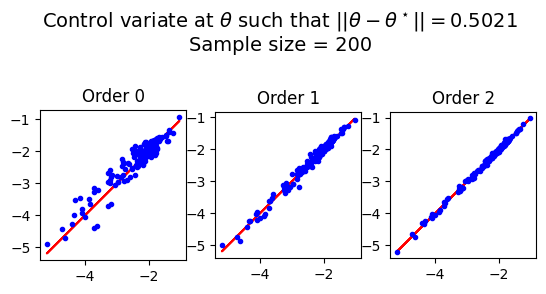

In [ ]:
dens_at_thetaStar, grad_at_thetaStar, Hess_at_thetaStar = dens_at_thetaStar_Poisson, grad_at_thetaStar_Poisson, Hess_at_thetaStar_Poisson
theta = np.random.multivariate_normal(thetaStar, test_sigma, size = 1).flatten()
q_k_order0 = eval_q_k(theta, dens_at_thetaStar, grad_at_thetaStar, Hess_at_thetaStar, order = 0) 
q_k_order1 = eval_q_k(theta, dens_at_thetaStar, grad_at_thetaStar, Hess_at_thetaStar, order = 1) 
q_k_order2 = eval_q_k(theta, dens_at_thetaStar, grad_at_thetaStar, Hess_at_thetaStar, order = 2) 
l_k = analytical_grad_hess(theta, init_sigma2=0.5)[0]['log_likelihood_at_i']
fig, axs = plt.subplots(1, 3)
fig.suptitle(
    r'Control variate at $\theta$ such that $||\theta - \theta^\star|| = %3.4f$' 
    % np.linalg.norm(theta - thetaStar)
    + "\nSample size = %s" % N,
    size=14,
    y = 1.02
)
# fig.subplots_adjust(top=0.2)

for k in range(3):
        axs[k].plot(l_k, l_k, color = 'red')
        if k == 0:
            axs[k].plot(l_k, q_k_order0, '.', color = 'blue')
            axs[k].set_title('Order 0', size = 12)
        elif k == 1:
            axs[k].plot(l_k, q_k_order1, '.', color = 'blue')
            axs[k].set_title('Order 1', size = 12)
        elif k == 2:
            axs[k].plot(l_k, q_k_order2, '.', color = 'blue')
            axs[k].set_title('Order 2', size = 12)
            
        axs[k].axis('scaled')

fig.subplots_adjust(top=1.2)
plt.show()